### Make a RL Environment about `Non-prehensile task` on table-top scene

In [1]:
import mujoco,torch
import numpy as np
import matplotlib.pyplot as plt
from mujoco_parser import MuJoCoParserClass
from util import r2rpy, sample_xyzs
from np_env import NonPrehensileMarkovDecisionProcessClass
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("Torch version:[%s]"%(torch.__version__))
print ("MuJoCo version:[%s]"%(mujoco.__version__))

Torch version:[1.13.1+cu116]
MuJoCo version:[2.3.4]


### Parse `UR5e`

In [2]:
xml_path = '../asset/ur5e/scene_ur5e_rg2_obj.xml'
env = MuJoCoParserClass(name='UR5e',rel_xml_path=xml_path,VERBOSE=False)
# Instantiate MDP
mdp = NonPrehensileMarkovDecisionProcessClass(env,HZ=50,history_total_sec=1.0,history_intv_sec=0.1,VERBOSE=True)

obj_names = [body_name for body_name in env.body_names
             if body_name is not None and (body_name.startswith("obj_"))]
n_obj = len(obj_names)
# Place objects
xyzs = sample_xyzs(n_sample=n_obj,
                   x_range=[0.72,0.95],y_range=[-0.38,0.38],z_range=[0.81,0.81],min_dist=0.2)
colors = np.array([plt.cm.gist_rainbow(x) for x in np.linspace(0,1,n_obj)])
for obj_idx,obj_name in enumerate(obj_names):
    jntadr = env.model.body(obj_name).jntadr[0]
    env.model.joint(jntadr).qpos0[:3] = xyzs[obj_idx,:]
    geomadr = env.model.body(obj_name).geomadr[0]
    env.model.geom(geomadr).rgba = colors[obj_idx] # color

# Move tables and robot base
env.model.body('base_table').pos = np.array([0,0,0])
env.model.body('front_object_table').pos = np.array([1.05,0,0])
env.model.body('side_object_table').pos = np.array([0,-0.85,0])
env.model.body('base').pos = np.array([0,0,0.8])
print ("Ready.")

[UR5e] Instantiated
   [info] dt:[0.0200] HZ:[50], env-HZ:[500], mujoco_nstep:[10], state_dim:[26], o_dim:[260], a_dim:[7]
   [history] total_sec:[1.00]sec, n:[50], intv_sec:[0.10]sec, intv_tick:[5]
   [history] ticks:[ 0  5 10 15 20 25 30 35 40 45]
Ready.


In [3]:
max_torque = 2
mdp.env.ctrl_ranges[:,0] = -max_torque
mdp.env.ctrl_ranges[:,1] = +max_torque
print ("mdp.env.ctrl_ranges:\n",mdp.env.ctrl_ranges)

mdp.env.ctrl_ranges:
 [[-2.  2.]
 [-2.  2.]
 [-2.  2.]
 [-2.  2.]
 [-2.  2.]
 [-2.  2.]
 [-2.  2.]]


### Loop with `mdp`

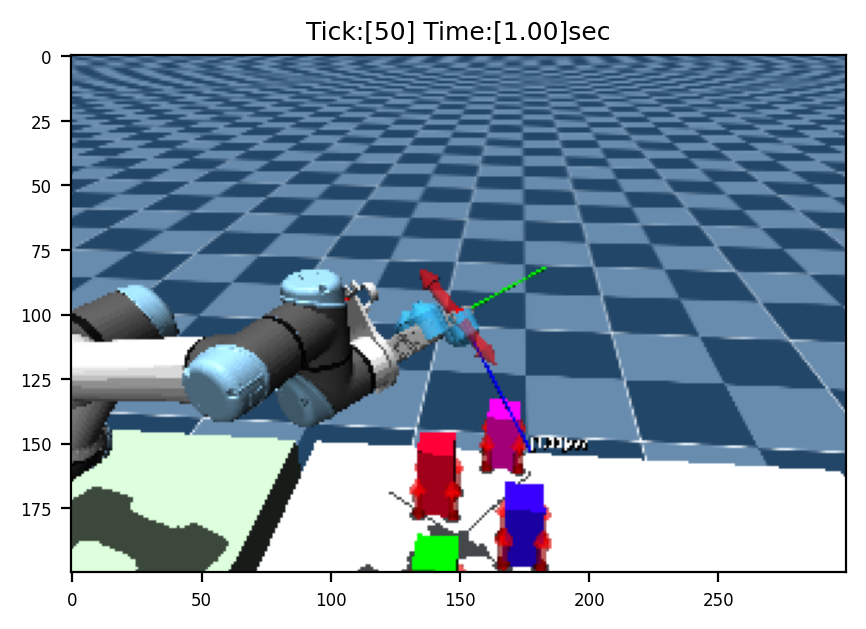

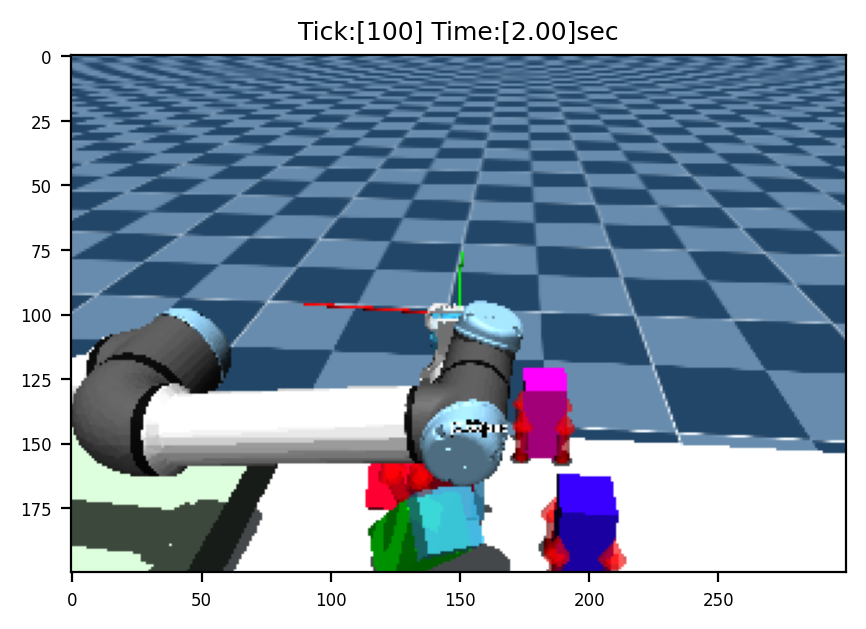

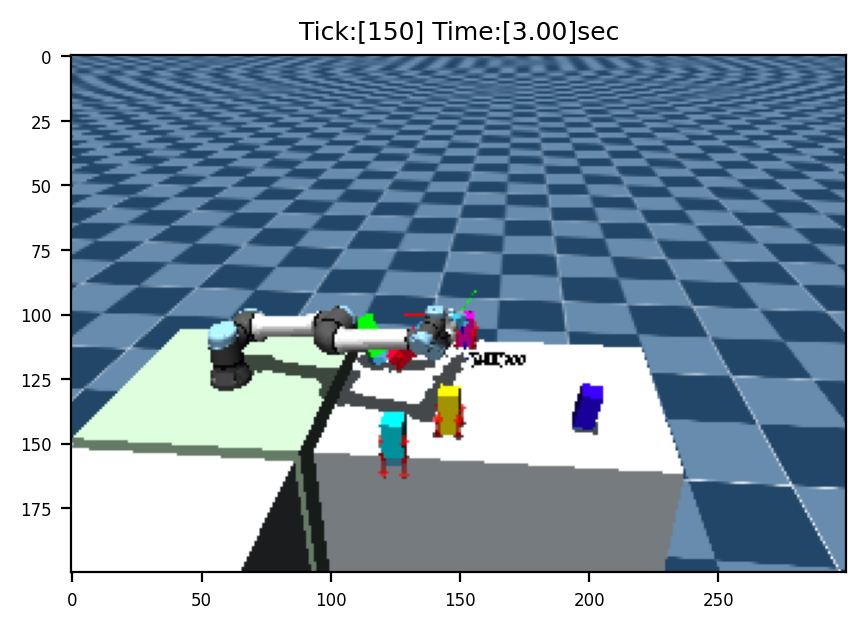

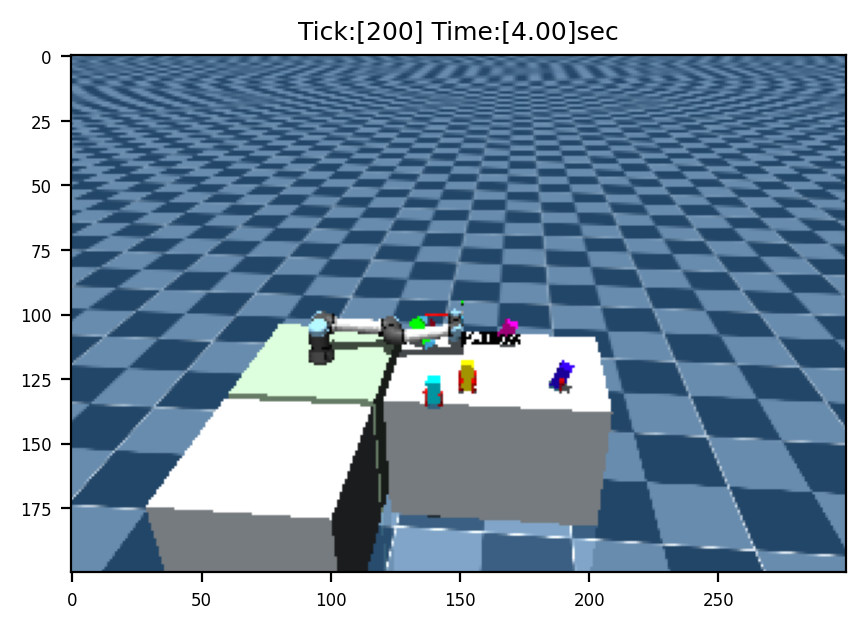

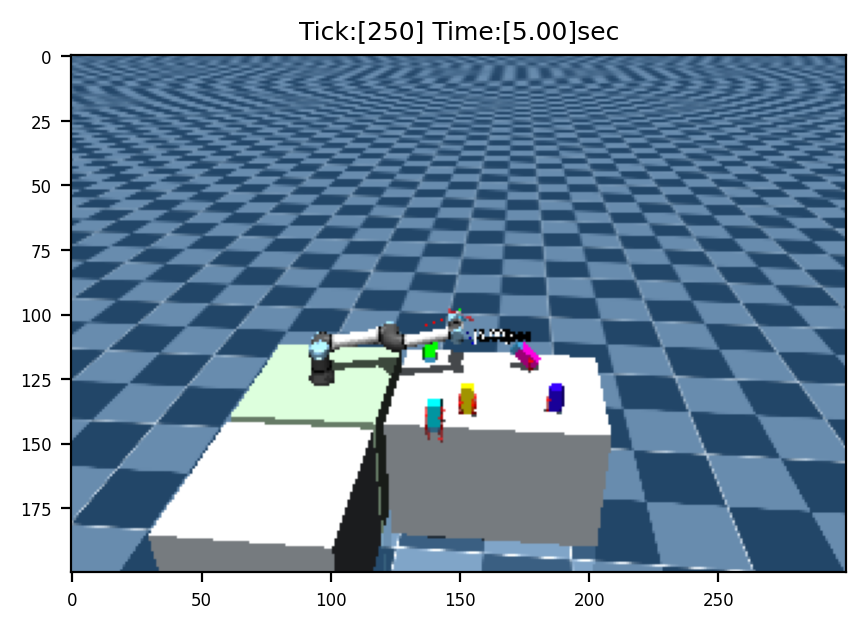

Pressed ESC
Quitting.
Done.


In [4]:
VERBOSE = False
# Initialize viewer
mdp.init_viewer()
# Loop
o = mdp.reset()
init_q = np.array([np.deg2rad(-90), np.deg2rad(-132.46), np.deg2rad(122.85), np.deg2rad(99.65), np.deg2rad(45), np.deg2rad(-90.02)])
mdp.env.forward(q=init_q,joint_idxs=mdp.env.idxs_forward)

max_time = 1000
while (mdp.get_sim_time() < max_time) and mdp.is_viewer_alive():
    
    # Step
    a = mdp.sample_action()
    o_prime,r,d,info = mdp.step(a=a,max_time=5.0)
    
    # Pause (if self collision occurred)
    # if info['SELF_COLLISION']: mdp.viewer_pause()
    
    # Render
    mdp.render(TRACK_EEF=True,PLOT_WORLD_COORD=True,PLOT_EEF_COORD=True,
               PLOT_SENSOR=True,PLOT_CONTACT=True,PLOT_TIME=True)
    
    # Print
    if VERBOSE:
        if (mdp.tick % 1) == 0:
            print ("tick:[%d] time:[%.2f]sec deg reward:[%.2f] done:[%d]"%
                (mdp.tick,mdp.get_sim_time(),r,d))
            print ("  Reward fwd:[%.2f]"%(info['r_forward']))

    # Plot
    if (mdp.tick % 50) == 0:
        scene_img = mdp.grab_image(resize_rate=0.25)
        plt.figure(figsize=(5,4)); plt.imshow(scene_img)
        plt.title("Tick:[%d] Time:[%.2f]sec"%(mdp.tick,mdp.get_sim_time()),fontsize=9)
        plt.show()

# Close viewer
mdp.close_viewer()
print ("Done.")